In [61]:
import matplotlib.style
matplotlib.style.use('classic')
#import matplotlib
#matplotlib.use("pdf")
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import click
import scipy as sp
from pypower.api import ppoption, runpf, printpf, makeYbus
from pypower.idx_gen import PG, QG, GEN_BUS
from pypower.idx_bus import PD, QD, VM, VA, BUS_I
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
import grid_cases as gridcase
from scipy.integrate import odeint
from scipy.integrate import ode
from scipy.interpolate import griddata
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import click
import time
from numba import autojit, jit, njit, cuda

In [46]:
#@autojit
def kuramoto_2nd_order( t, x, P, K, alfs ):
    N = int(len( P ))
    theta = x[:N]
    dot_theta = x[N:]
    dotdot_theta = np.zeros( 2*N )
    dotdot_theta[0:N] = dot_theta
    dotdot_theta[N:] = P - np.multiply( alfs, dot_theta ) + np.sum(K * np.sin( np.repeat( theta.reshape(N,1).T, N, axis=0 ) - np.repeat( theta.reshape(N,1), N, axis=1 ) ), axis=1)

    return dotdot_theta

#@autojit
def synch_condition( K, w ):
    '''
    Returns an approximation to the critical coupling and to the steady state
    of the system, calculated from topological considerations.
    '''
    G = nx.from_numpy_matrix(K)
    L_dagger = np.linalg.pinv( nx.laplacian_matrix( G ).todense() )
    B = nx.incidence_matrix( G, oriented = True ).todense()
    theta_ss = np.matmul(L_dagger, w) 
    x0 = np.concatenate((theta_ss, 0*theta_ss), axis=1).T
    x0 = x0.flatten()
    x0 = x0.tolist()
    x0 = x0[0]
    k_crit = np.linalg.norm( np.matmul( B.T, theta_ss.T ), np.inf )

    return k_crit, x0

In [113]:
#@cuda.jit()
def each_run(x0, t_fin, stead_time, K, P, Alf, to_plot, wrap_pi):
    N = len(P)
    solver = ode( kuramoto_2nd_order )
    solver.set_integrator('vode', method = 'bdf', order = 5, nsteps=3000)
    solver.set_f_params(P, K, Alf)
    solver.set_initial_value(x0, 0)

    i = 0
    states = []
    t = []
    while solver.successful() and solver.t < t_fin:
        solver.integrate(1, step=True) 
        states.append( solver.y )
        t.append(solver.t)
        i += 1

    t = np.array(t)
    states = np.array(states)



    if (wrap_pi):
        phases = ( states[:,0:N] + np.pi) % (2 * np.pi ) - np.pi
    else:
        phases = states[:,0:N]

    phase_vels = states[:,N:]


    re_r = np.mean( np.cos( phases ), axis = 1 )
    im_r = np.mean( np.sin( phases ), axis = 1 )
    mag_r = np.sqrt( np.square(re_r) + np.square(im_r) )
    avg_vel = np.sqrt( np.mean( np.square(phase_vels) , axis = 1 ) )


    stead_re_r = np.mean( re_r[ t > stead_time ] )
    stead_mag_r = np.mean( mag_r[ t > stead_time ] )
    stead_avg_vel = np.mean( avg_vel[ t > stead_time ] )

    stead_results = np.array( [ x0[0], x0[1], stead_mag_r, stead_re_r, stead_avg_vel] ) 



    if (to_plot):

        plt.figure()
        plt.plot(t, re_r, c = 'dodgerblue', label = r"$I\!Re [r_{(t)}]$")
        plt.plot(t, im_r, c = 'mediumvioletred', label = r"$I\!Im [r_{(t)}]$")
        plt.plot(t, mag_r, c = 'darkorange', label = r"$|r_{(t)}|$")
        plt.xlabel(r'$t ~~~ \rm{[s]}$')
        plt.legend()
        plt.grid()
        #plt.xlim([0,10])
        plt.ylim([-1.1,1.1])
        plt.show()


        phases = phases[:, :50]
        phase_vels = phase_vels[:, :50]


        plt.figure()
        plt.plot(t, phases)
        plt.ylabel(r'$\theta$')
        plt.xlabel(r'$t ~~~ \rm{[s]}$')
        plt.grid()
        #plt.xlim([0,10])
        #plt.ylim([-20,20])
        plt.show()

        plt.figure()
        plt.plot(t, phase_vels)
        plt.ylabel(r'$\dot \theta$')
        plt.xlabel(r'$t ~~~ \rm{[s]}$')
        plt.grid()
        #plt.xlim([0,10])
        #plt.ylim([-20,20])
        plt.show()
    return stead_results

In [130]:
#@cuda.jit()
def da_run(t_fin, stead_time, K, P, Alf, to_plot, wrap_pi):
    stead_results = list()
    simindx = 0
    for d_0 in np.linspace( -2*np.pi, 2*np.pi, 60 ): 
        print(simindx/60)
        simindx = simindx + 1
        for d_1 in np.linspace( -2*np.pi, 2*np.pi, 60 ):
            x0 = [d_0, d_1, 0.0, 0.0, 0.0, 0.0]
            part_results = each_run(x0, t_fin, stead_time, K, P, Alf, to_plot, wrap_pi)
            stead_results.append( part_results )
    stead_results = np.array(stead_results)            
    return stead_results

In [121]:
@jit
def initstate_sweep(t_fin, stead_time, K, P, Alf, to_plot, wrap_pi):
    start_time = time.time()
    
    stead_results = da_run(t_fin, stead_time, K, P, Alf, to_plot, wrap_pi)
    end_time = time.time()
    print( 'Execution time:', end_time - start_time )
    return stead_results

In [131]:
K = 8*np.array([ [0.0, 1.0, 1.0], [1.0, 0.0, 1.0], [1.0, 1.0, 0.0] ])
P = np.array([ 1.0, -1.0, 0.0 ] )
Alf = np.zeros(3)

to_plot = False
wrap_pi = True
t_fin = 200 
stead_time = 100

k_crit, x0 = synch_condition( K, P )

print('K_crit: ', k_crit)



K_crit:  0.08333333333333336


In [123]:
%matplotlib notebook

In [132]:
stead_results = initstate_sweep(t_fin, stead_time, K, P, Alf, to_plot, wrap_pi)


0.0
0.016666666666666666
0.03333333333333333
0.05
0.06666666666666667
0.08333333333333333
0.1
0.11666666666666667
0.13333333333333333
0.15
0.16666666666666666
0.18333333333333332
0.2
0.21666666666666667
0.23333333333333334
0.25
0.26666666666666666
0.2833333333333333
0.3
0.31666666666666665
0.3333333333333333
0.35
0.36666666666666664
0.38333333333333336
0.4
0.4166666666666667
0.43333333333333335
0.45
0.4666666666666667
0.48333333333333334
0.5
0.5166666666666667
0.5333333333333333
0.55
0.5666666666666667
0.5833333333333334
0.6
0.6166666666666667
0.6333333333333333
0.65
0.6666666666666666
0.6833333333333333
0.7
0.7166666666666667
0.7333333333333333
0.75
0.7666666666666667
0.7833333333333333
0.8
0.8166666666666667
0.8333333333333334
0.85
0.8666666666666667
0.8833333333333333
0.9
0.9166666666666666
0.9333333333333333
0.95
0.9666666666666667
0.9833333333333333
Execution time: 5579.700236320496


In [133]:
stead_results = np.array(stead_results)

In [134]:
x_ax = stead_results[:,0]
y_ax = stead_results[:,1]

X_space, Y_space = np.meshgrid( np.sort(np.unique(x_ax)), np.sort(np.unique(y_ax)) ) 

<IPython.core.display.Javascript object>


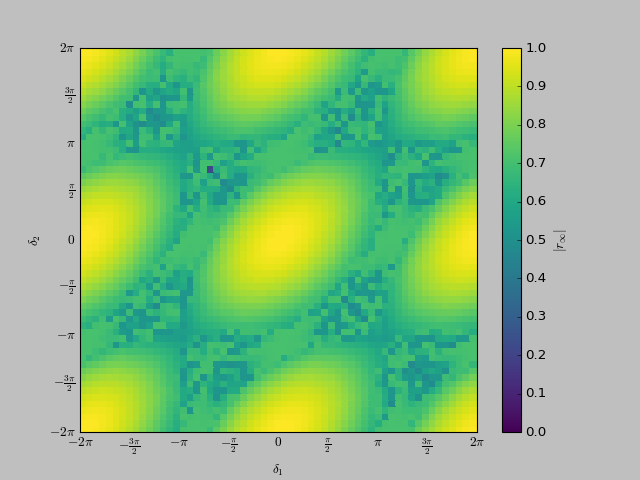

In [135]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
values = stead_results[:,2]
Z_space = griddata(stead_results[:,0:2], values, (X_space, Y_space), method ='nearest' )
im = ax1.pcolormesh( X_space, Y_space, Z_space, cmap = plt.cm.viridis, vmin = 0, vmax = 1, edgecolors = 'face')
cbar = fig.colorbar(im, ax = ax1)
cbar.set_label(r'$|r_{\infty}|$')

ax1.set_xlabel(r'$\delta_1$')
ax1.set_xticks([-2*np.pi, -1.5*np.pi, -np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax1.set_xticklabels([r"$-2\pi$", r"$-\frac{3\pi}{2}$", r"$-\pi$", r"$-\frac{\pi}{2}$",
    "$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
ax1.set_yticks([-2*np.pi, -1.5*np.pi, -np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax1.set_yticklabels([r"$-2\pi$", r"$-\frac{3\pi}{2}$", r"$-\pi$", r"$-\frac{\pi}{2}$",
    "$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
ax1.set_ylabel(r'$\delta_2$')
ax1.set_xlim([-2*np.pi, 2*np.pi])
ax1.set_ylim([-2*np.pi, 2*np.pi])
ax1.xaxis.set_ticks_position('none') 
ax1.yaxis.set_ticks_position('none') 
plt.savefig('Images_2/map_magr_triangular.pdf')
plt.show()

<IPython.core.display.Javascript object>


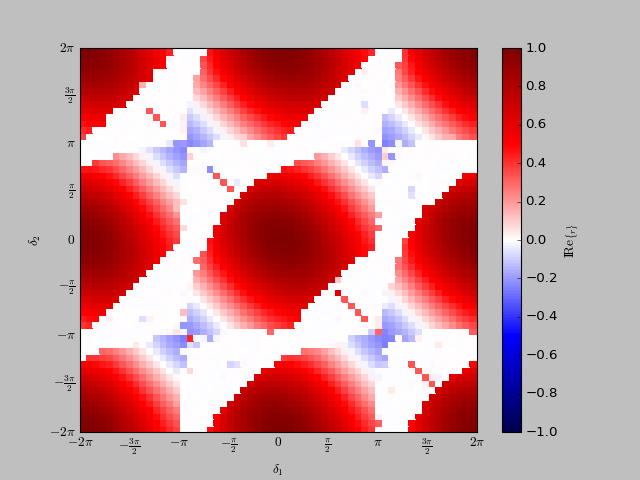

In [144]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

values = stead_results[:,3]
Z_space = griddata(stead_results[:,0:2], values, (X_space, Y_space), method ='nearest' )
im = ax1.pcolormesh( X_space, Y_space, Z_space, cmap = plt.cm.seismic, vmin = -1, vmax = 1, edgecolors = 'face')
cbar = fig.colorbar(im, ax = ax1)
cbar.set_label(r'${\rm I\!R e}_{ \{ r \} }$')
ax1.set_xlabel(r'$\delta_1$')
ax1.set_xticks([-2*np.pi, -1.5*np.pi, -np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax1.set_xticklabels([r"$-2\pi$", r"$-\frac{3\pi}{2}$", r"$-\pi$", r"$-\frac{\pi}{2}$",
    "$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
ax1.set_yticks([-2*np.pi, -1.5*np.pi, -np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax1.set_yticklabels([r"$-2\pi$", r"$-\frac{3\pi}{2}$", r"$-\pi$", r"$-\frac{\pi}{2}$",
    "$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
ax1.set_ylabel(r'$\delta_2$')
ax1.set_xlim([-2*np.pi, 2*np.pi])
ax1.set_ylim([-2*np.pi, 2*np.pi])
ax1.xaxis.set_ticks_position('none') 
ax1.yaxis.set_ticks_position('none') 
plt.savefig('Images_2/map_rer_triangular.pdf')
plt.show()

<IPython.core.display.Javascript object>


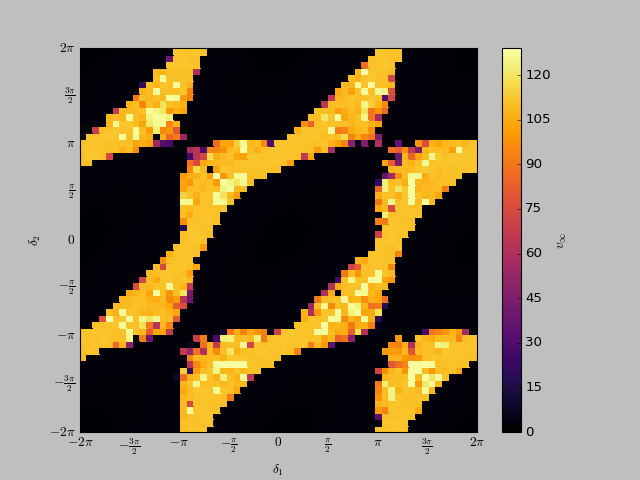

In [142]:

fig = plt.figure()
ax1 = fig.add_subplot(111)
values = stead_results[:,4]
Z_space = griddata(stead_results[:,0:2], values, (X_space, Y_space), method ='nearest' )
im = ax1.pcolormesh( X_space, Y_space, Z_space, cmap = plt.cm.inferno, vmin = 0, vmax = np.max(values), edgecolors = 'face')
cbar = fig.colorbar(im, ax = ax1)
cbar.set_label(r'$v_{\infty}$')
ax1.set_xlabel(r'$\delta_1$')
ax1.set_xticks([-2*np.pi, -1.5*np.pi, -np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax1.set_xticklabels([r"$-2\pi$", r"$-\frac{3\pi}{2}$", r"$-\pi$", r"$-\frac{\pi}{2}$",
    "$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
ax1.set_yticks([-2*np.pi, -1.5*np.pi, -np.pi, -0.5*np.pi, 0., 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax1.set_yticklabels([r"$-2\pi$", r"$-\frac{3\pi}{2}$", r"$-\pi$", r"$-\frac{\pi}{2}$",
    "$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
ax1.set_ylabel(r'$\delta_2$')

ax1.xaxis.set_ticks_position('none') 
ax1.yaxis.set_ticks_position('none') 

ax1.set_xlim([-2*np.pi, 2*np.pi])
ax1.set_ylim([-2*np.pi, 2*np.pi])
plt.savefig('Images_2/map_vinf_triangular.pdf')
plt.show()

<IPython.core.display.Javascript object>


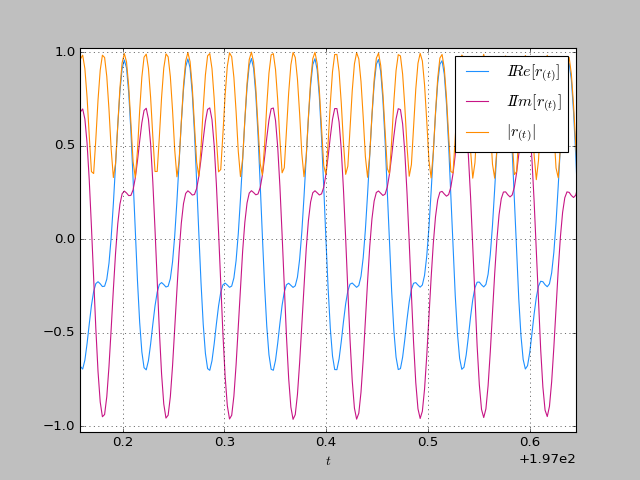

<IPython.core.display.Javascript object>


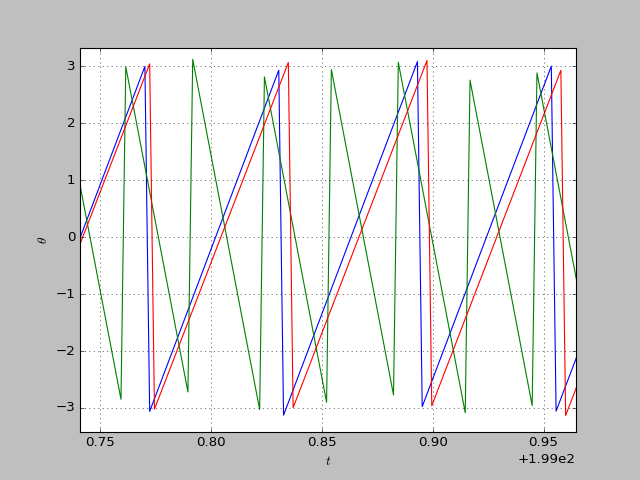

<IPython.core.display.Javascript object>


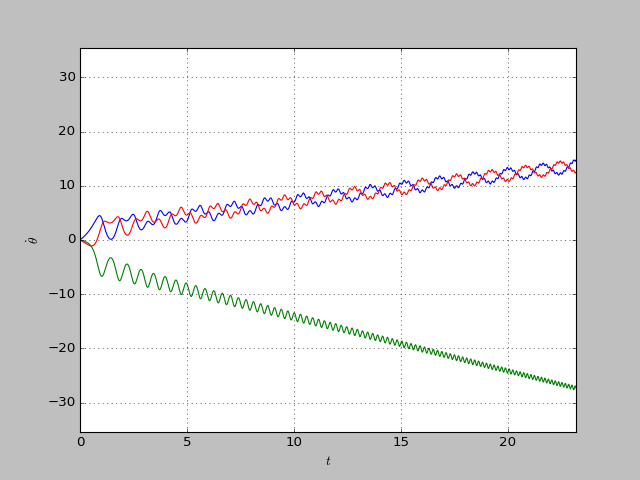

In [147]:
x0 = [-np.pi/2, (-3*np.pi/2)+np.pi/4, 0.0, 0.0, 0.0, 0.0]
part_results = each_run(x0, t_fin, stead_time, K, P, Alf, True, wrap_pi)

In [146]:
part_results

array([-1.57079633e+00, -3.92699082e+00,  6.96272328e-01,  2.10476606e-04,
        1.10858881e+02])